# Juxtapose Two Corpus (Similarity and Polarity)

**Appropriate datasets:**
1. Tweets

**Required metadata:**
1. datetime

**Methods (Using political tweets dataset):**
1. slice the corpus into quintile 0 and quintile 4 (Left-wing, Right-wing)
2. slice the quintile 0 and quintile 4 each into monthly corpus.

**This notebook answers the following which requires more and more granular analysis:**

*1. When is there peak activity?*

Plot monthly corpus size to reveal peaks

*2. How similar are these corpus?*

Corpus similarity using cosine similarity on different metrics. (todo: this can actually be a heatmap)

*3. During the month of peak activity, what are the left saying compared to the right?*

Wordcloud that shows the more representative words and coloured based on their dominance.

In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

'Working directory: /Users/sjuf9909/Documents/GitHub/juxtorpus'

In [3]:
from juxtorpus.viz.widgets import FileUploadWidget

# please upload in .zip format of the directories
fwidget = FileUploadWidget()
fwidget.widget()

[INFO] Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.


ModuleNotFoundError: No module named 'sklearn'

In [6]:
f"You have uploaded {len(fwidget.uploaded())} files."

'You have uploaded 1334 files.'

In [7]:
# Tristram project specific: transform text files into csv.
from scripts.tristram.quintiles_to_csv import transform
dirs = set(f.parent for f in fwidget.uploaded())
csv_paths = [transform(d) for d in dirs]

csv_paths

[INFO] Parsing files in /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_0 to dataframe...
[INFO] Number of files: 667
[INFO] Written to /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_0/Quintile_0.csv. Size: 147.328337Mb.
[INFO] Parsing files in /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_4 to dataframe...
[INFO] Number of files: 667
[INFO] Written to /var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_4/Quintile_4.csv. Size: 20.980418Mb.


[PosixPath('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_0/Quintile_0.csv'),
 PosixPath('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmpbzani7eg/Quintile_4/Quintile_4.csv')]

In [3]:
from pathlib import Path
# csv_paths = [Path('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmp3sdug0o_/Quintile_0/Quintile_0.csv'),
#             Path('/var/folders/jh/mqv5k4x56d98m2twhmk4bjdc0000gp/T/tmp3sdug0o_/Quintile_4/Quintile_4.csv')]

csv_paths = fwidget.uploaded()

import pandas as pd
pd.read_csv(csv_paths[0], nrows=1)

text  quintile        date
0  <TWEET> @TracyPa08213034 @AdamBandt That's 97%...         4  2021/12/27

In [4]:
from juxtorpus.corpus import CorpusBuilder

builder = CorpusBuilder(csv_paths)
builder.summary().T

All Columns date quintile text
Text                          
Meta                          
Dtype

In [5]:
builder.add_metas(['quintile'])
builder.add_metas('date', 'datetime')

import re
pattern = re.compile(r'<[/]?TWEET>')

builder.set_text_column('text')
builder.set_text_preprocessors([lambda t: pattern.sub('', t).strip()])
corpus = builder.build()
corpus.summary()

[INFO] Building document-term matrix. Please wait...
[INFO] Done.


Corpus Type                Corpus
No. Documents              831078
No. Terms                22833470
Vocabulary size            486152
No. Terms mean          27.474521
No. Terms std           14.696279
No. Terms min                 1.0
No. Terms 25%                16.0
No. Terms 50%                26.0
No. Terms 75%                40.0
No. Terms max               113.0
metas              quintile, date
dtype: object

In [11]:
# You may choose to skip this step
# corpus = corpus.slicer.sample(1000)
# corpus.summary().to_frame().T

# When is there peak activity?

In [6]:
quintiles = list(corpus.slicer.group_by('quintile'))
quintiles

[(0, <juxtorpus.corpus.corpus.Corpus at 0x2b4ca0730>),
 (4, <juxtorpus.corpus.corpus.Corpus at 0x2c89971c0>)]

In [7]:
# create a timeline using
import pandas as pd
import plotly.graph_objects as go

traces = list()
for qid, quintile in quintiles:
    time_period_groups = list(quintile.slicer.group_by('date', pd.Grouper(freq='1m')))
    trace = go.Scatter(x=[g for g, _ in time_period_groups], 
                       y=[len(c) for _, c in time_period_groups],
                      name=f"quintile {qid}")
    traces.append(trace)
# traces
fig = go.Figure(traces)
fig.update_xaxes(
    dtick="M1"
)
fig.update_layout(
    title=f"Number of tweets by month",
)
fig.show()

# How similar are these corpus?

The corpus similarity is measured using cosine similarity with a few different metrics to select from.
1. Normalised term frequency
2. TFIDF
3. Log likelihood with a baseline

In [8]:
# todo: bar, heatmap

# During the month of peak activity, what are the left saying compared to the right?

In [9]:
jan = corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01')

In [10]:
groups = list(jan.slicer.group_by('quintile'))
q0, q4 = groups[0][1], groups[1][1]
q0, q4

(<juxtorpus.corpus.corpus.Corpus at 0x2c81eb9d0>,
 <juxtorpus.corpus.corpus.Corpus at 0x2c8206f40>)

In [11]:
from juxtorpus import Jux

jux = Jux(q0, q4)
jux.summary().T

Corpus Type No. Documents No. Terms Vocabulary size No. Terms mean  \
corpus_0      Corpus        134284   3675719          109651      27.372725   
corpus_1      Corpus         19448    537940           30030      27.660428   

         No. Terms std No. Terms min No. Terms 25% No. Terms 50%  \
corpus_0     14.427928           1.0          16.0          26.0   
corpus_1     16.112685           1.0          14.0          25.0   

         No. Terms 75% No. Terms max           metas  
corpus_0          40.0         106.0  quintile, date  
corpus_1          41.0         106.0  quintile, date

## Word Cloud: term frequency

In [12]:
df = jux.polarity.tf()

In [13]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

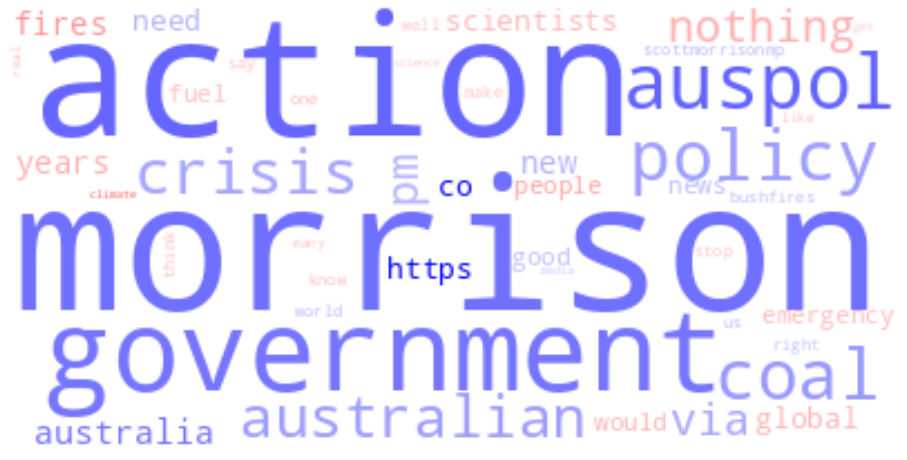

In [14]:
df = df[~df.index.isin(sw)]
df['summed'] = df['freq_corpus_0'] + df['freq_corpus_1']
df['polarity_div_summed'] = df['polarity'].abs() / df['summed']

top = 50
df_tmp = df.sort_values(by='summed', ascending=False).iloc[:top]

from juxtorpus.viz.polarity_wordcloud import PolarityWordCloud
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='polarity_div_summed')
pwc.gradate('blue', 'red').render(16, 16)

## Word Cloud: TFIDF

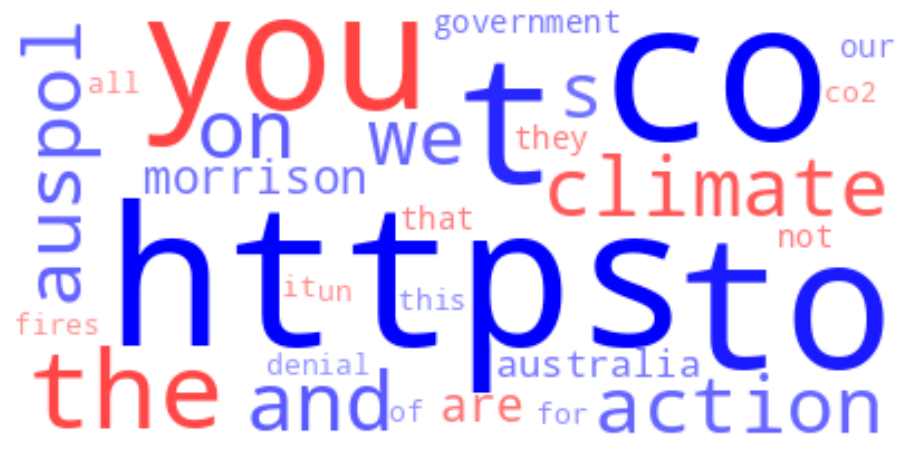

In [15]:
df = jux.polarity.tfidf()
df['size'] = df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

## Word Cloud: Log Likelihood

The larger the size the more 'representative' it is of both corpus.

The colour gradient describes how 'polarised' it is.

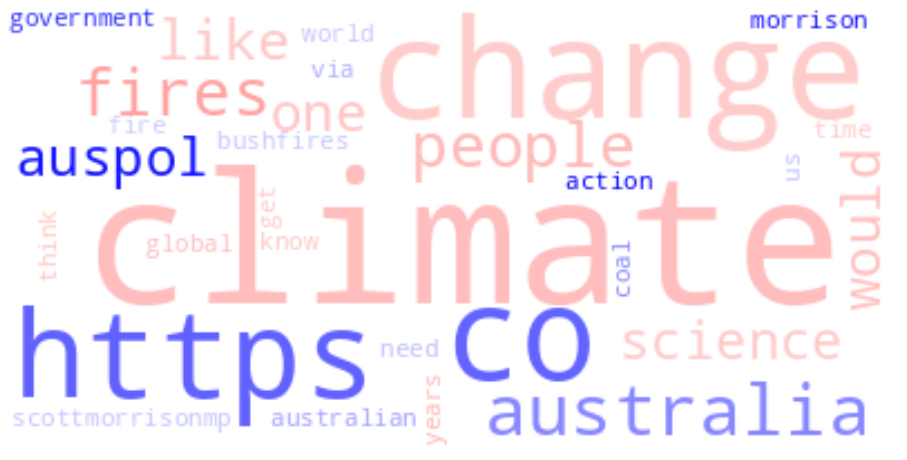

In [16]:
# Size = TF.abs()   Polarity = LLV

df = jux.polarity.log_likelihood()
tf_df = jux.polarity.tf()
df['size'] = tf_df['freq_corpus_0'] + tf_df['freq_corpus_1']
df = df[~df.index.isin(sw)]
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

In [17]:
df_tmp

log_likelihood_llv  bayes_factor_bic  effect_size_ell  \
climate                   86.384515         71.130673     2.134588e-06   
change                     2.942457        -12.311385     7.756484e-08   
co                       594.576571        579.322729     1.579706e-05   
https                    599.566751        584.312909     1.593899e-05   
australia                394.629506        379.375664     1.212846e-05   
fires                    226.586983        211.333141     7.507515e-06   
people                   102.809221         87.555379     3.403429e-06   
like                      14.833505         -0.420337     5.062028e-07   
science                    4.998518        -10.255324     1.722081e-07   
auspol                  1021.991279       1006.737437     3.339958e-05   
would                     56.350936         41.097094     1.967739e-06   
one                       34.286149         19.032307     1.200585e-06   
scottmorrisonmp           45.863583         30.609741     1.580803e-06   
time                       0.001708        -15.252133     5.975503e-11   
world                     31.974522         16.720680     1.111339e-06   
action                  1153.660759       1138.406917     3.837424e-05   
australian               230.750426        215.496584     7.925041e-06   
bushfires                 26.938124         11.684282     9.461952e-07   
us                        39.146247         23.892405     1.372752e-06   
need                      71.694881         56.441039     2.506553e-06   
government               887.221468        871.967626     2.995646e-05   
get                        3.185656        -12.068186     1.139604e-07   
fire                       0.115853        -15.137989     4.131270e-09   
via                      162.566826        147.312984     5.673166e-06   
morrison                1060.216961       1044.963119     3.581949e-05   
years                    120.001675        104.747833     4.430932e-06   
know                      27.791128         12.537286     1.017173e-06   
think                     22.735083          7.481241     8.434277e-07   
global                    69.743959         54.490117     2.643282e-06   
coal                     395.380746        380.126904     1.402828e-05   

                    polarity      size  polarity_normalised_  
climate           -86.384515  0.056821              1.462561  
change             -2.942457  0.030446              1.498725  
co                594.576571  0.025136              1.757691  
https             599.566751  0.024985              1.759854  
australia         394.629506  0.007076              1.671034  
fires            -226.586983  0.005641              1.401797  
people           -102.809221  0.005389              1.455442  
like              -14.833505  0.004083              1.493571  
science            -4.998518  0.003752              1.497834  
auspol           1021.991279  0.003741              1.942934  
would             -56.350936  0.003669              1.475577  
one               -34.286149  0.003527              1.485140  
scottmorrisonmp    45.863583  0.003331              1.519877  
time               -0.001708  0.003292              1.499999  
world              31.974522  0.003185              1.513858  
action           1153.660759  0.003150              2.000000  
australian        230.750426  0.003063              1.600008  
bushfires          26.938124  0.002976              1.511675  
us                 39.146247  0.002966              1.516966  
need               71.694881  0.002940              1.531073  
government        887.221468  0.002916              1.884524  
get                -3.185656  0.002902              1.498619  
fire                0.115853  0.002874              1.500050  
via               162.566826  0.002808              1.570457  
morrison         1060.216961  0.002807              1.959501  
years            -120.001675  0.002726              1.447991  
know              -27

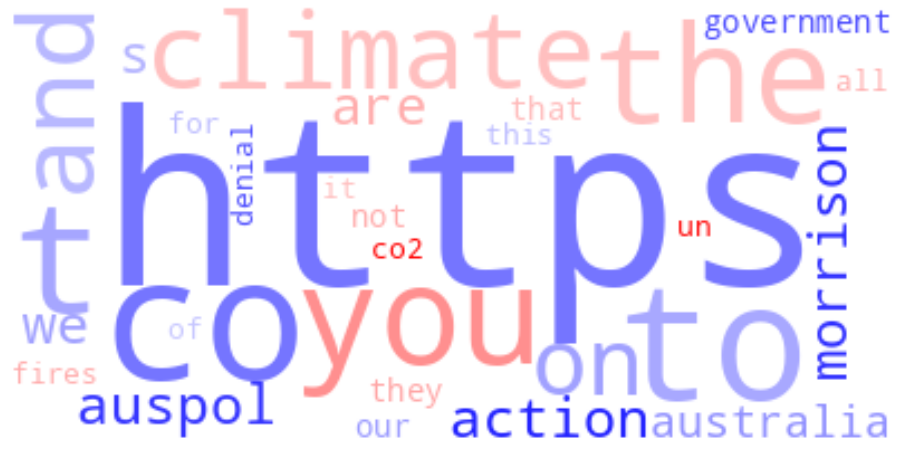

In [18]:
# Size = TFIDF.abs()   Polarity = LLV
df = jux.polarity.log_likelihood()
tfidf_df = jux.polarity.tfidf()
df['size'] = tfidf_df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:30]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

In [19]:
# Size = baseline extracted keywords, Polarity = LLV

import pandas as pd
from juxtorpus.corpus.freqtable import FreqTable


freqtbl_baseline = FreqTable(list(), list())
freqtbl_baseline._series = pd.read_csv('./assets/baselines/auspol_freqtable.csv', index_col=0).dropna().squeeze().rename('freq')
# issue duplicate index can't be concatenated. Hence dropped here.
freqtbl_baseline._series.drop(freqtbl_baseline._series.loc[freqtbl_baseline.series.index.duplicated()].index, inplace=True)

In [20]:
from juxtorpus.stats.loglikelihood_effectsize import log_likelihood_and_effect_size
llv_baseline = log_likelihood_and_effect_size([corpus.dtm.freq_table(), freqtbl_baseline])
llv_baseline.head(3)

freq_corpus_0  freq_corpus_1  expected_likelihoods  \
0           1778.0        19863.0              0.000122   
00           147.0         1501.0              0.000009   
000         4591.0        46421.0              0.000288   

     expected_freq_corpus_0  log_likelihood_ratio_corpus_0  \
0               2787.381205                      -0.449613   
00               212.263954                      -0.367398   
000             6570.393699                      -0.358476   

     log_likelihood_corpus_0  expected_freq_corpus_1  \
0               -1598.825186            18853.618795   
00               -108.015006             1435.736046   
000             -3291.525615            44441.606301   

     log_likelihood_ratio_corpus_1  log_likelihood_corpus_1  \
0                         0.052154              2071.863076   
00                        0.044454               133.450640   
000                       0.043576              4045.667539   

     log_likelihood_llv  bayes_factor_bic  effect_size_ell  
0            473.037890        454.044665     3.363670e-07  
00            25.435634          6.442409     2.677939e-08  
000          754.141924        735.148699     4.839440e-07

In [21]:
llvb = llv_baseline
relative = llvb['freq_corpus_0'] - llvb['freq_corpus_1']
llvb['log_likelihood_llv_signed'] = (relative*llvb.log_likelihood_llv) / relative.abs()
llvb.log_likelihood_llv_signed.head(3)

0     -473.037890
00     -25.435634
000   -754.141924
Name: log_likelihood_llv_signed, dtype: float64

In [22]:
# use the llv_baseline to find the keywords
hard_threshold = 3.4

f"Before removal: {len(llvb)}, After: {len(llvb[llvb.log_likelihood_llv_signed > hard_threshold])}"

'Before removal: 1638929, After: 16929'

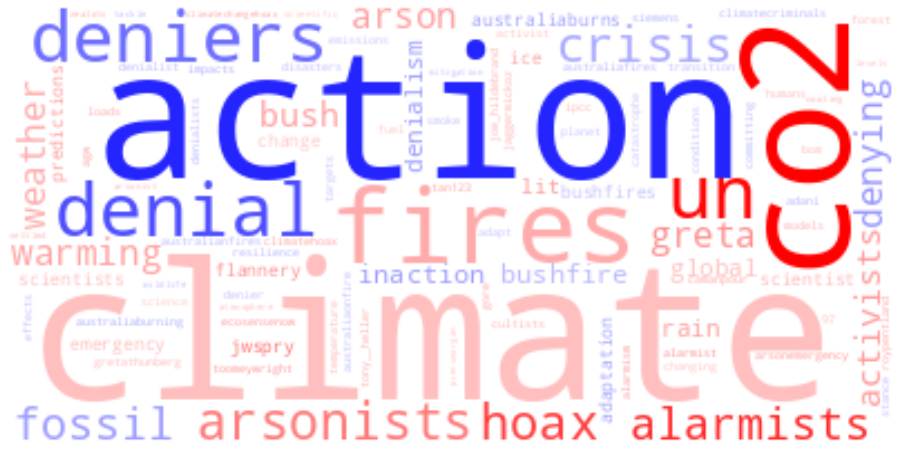

In [23]:
df = jux.polarity.log_likelihood()
# preprocessing - remove non keywords
df['llvb_signed'] = llvb.log_likelihood_llv_signed
df = df[df['llvb_signed'] > hard_threshold]

tfidf_df = jux.polarity.tfidf()
df['size'] = tfidf_df.polarity.abs()
df_tmp = df.sort_values(by='size', ascending=False).iloc[:100]
pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='size')
pwc.gradate('blue', 'red').render(16, 16)

## Wordcloud: # only

In [24]:
import spacy
from juxtorpus.corpus.processors import process

nlp = spacy.blank('en')

s_corpus = process(corpus, nlp=nlp)
s_corpus.summary()

[INFO] Processing corpus of 831078 documents...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.


Corpus Type           SpacyCorpus
No. Documents              831078
No. Terms                19834101
Vocabulary size            114212
No. Terms mean          23.865511
No. Terms std            13.51187
No. Terms min                 0.0
No. Terms 25%                12.0
No. Terms 50%                22.0
No. Terms 75%                36.0
No. Terms max                62.0
metas              quintile, date
dtype: object

In [25]:
s = s_corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01')

In [26]:
list(s.slicer.group_by('quintile'))

[(0, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2d3f3f2e0>),
 (4, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2d3f3f7f0>)]

In [27]:
list(s_corpus.slicer.group_by('quintile'))

[(0, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2d3f10520>),
 (4, <juxtorpus.corpus.corpus.SpacyCorpus at 0x2d3f10d60>)]

In [28]:
# this is a new corpus after being processed by spacy, so we need to slice and create jux again.
groups = list(s_corpus.slicer.filter_by_datetime('date', start='2020-01-01', end='2020-02-01').slicer.group_by('quintile'))
q0, q4 = groups[0][1], groups[1][1]
jux = Jux(q0, q4)

[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.


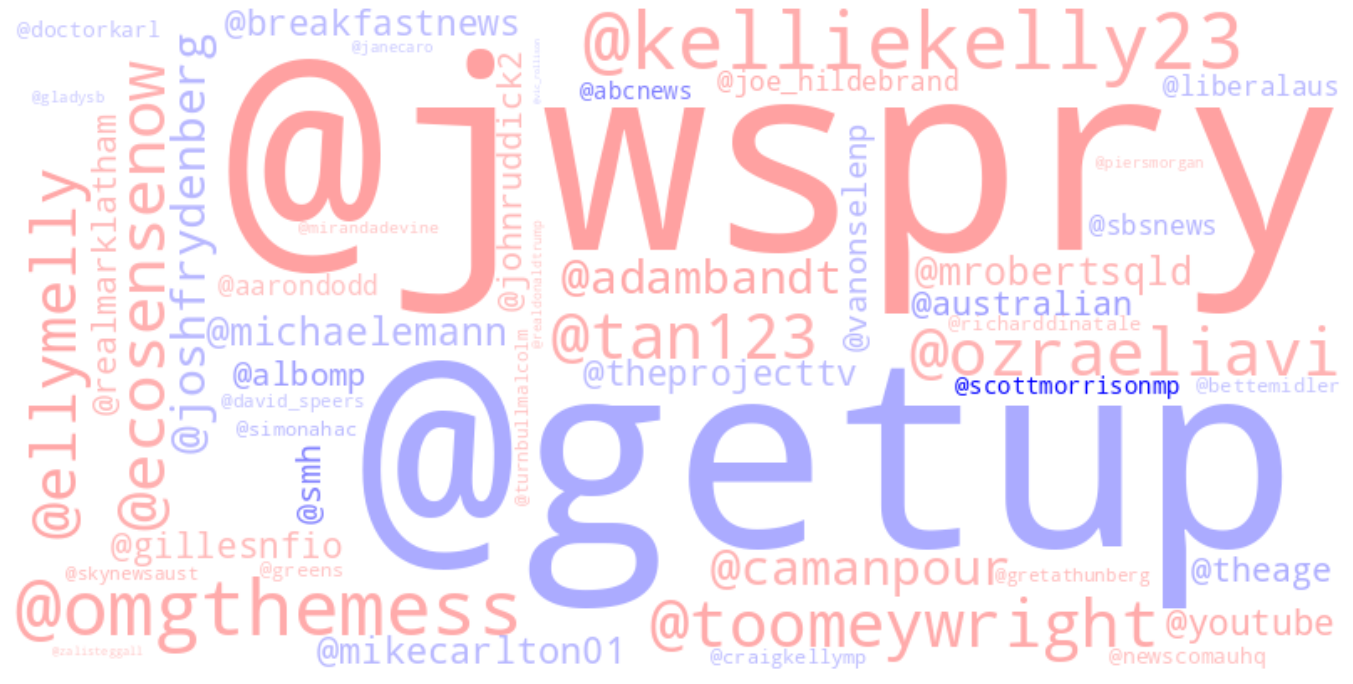

In [29]:
from juxtorpus.matchers import hashtags, at_mentions

# matcher = hashtags(nlp.vocab)
matcher = at_mentions(nlp.vocab)
def gen_hashtags_from(doc):
    return (doc[s:e].text.lower() for _, s, e in matcher(doc))
    

df = jux.polarity.tf(tokeniser_func=gen_hashtags_from)

df['summed'] = df['freq_corpus_0'] + df['freq_corpus_1']
df['polarity_div_summed'] = df['polarity'].abs() / df['summed']

top = 50
df_tmp = df.sort_values(by='summed', ascending=False).iloc[:top]

pwc = PolarityWordCloud(df_tmp, col_polarity='polarity', col_size='polarity_div_summed')
pwc.gradate('blue', 'red').render(24, 24)

In [58]:
corpus = jux.corpus_1
groups = list(corpus.slicer.group_by('date', grouper=pd.Grouper(freq='1d')))
groups[:3]

[(Timestamp('2020-01-02 00:00:00', freq='D'),
  <juxtorpus.corpus.corpus.SpacyCorpus at 0x303e2c2b0>),
 (Timestamp('2020-01-03 00:00:00', freq='D'),
  <juxtorpus.corpus.corpus.SpacyCorpus at 0x303e1bfa0>),
 (Timestamp('2020-01-04 00:00:00', freq='D'),
  <juxtorpus.corpus.corpus.SpacyCorpus at 0x30393e6d0>)]

In [57]:
corpus.create_custom_dtm(tokeniser_func=gen_hashtags_from)

[INFO] Building document-term matrix. Please wait...
[INFO] Done.


<DTM 19448 docs X 6085 terms>

In [63]:
dtms[0].freq_table()

In [59]:
# create custom hashtag dtm for each corpus
dtms = [c.create_custom_dtm(tokeniser_func=gen_hashtags_from) for _, c in groups]

[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Building document-term matrix. Please wait...
[INFO] Done.
[INFO] Bui

In [60]:
dtms[0].freq_table().series.sort_values(ascending=False)

@scottmorrisonmp    59
@newscomauhq        15
@albomp             15
@larissawaters      15
@skynewsaust        14
                    ..
@heargene            1
@hazardplane6        1
@hardfastandfree     1
@happyharrymedia     1
@kev_metcalfe        1
Name: freq, Length: 595, dtype: int64

In [61]:
import plotly.graph_objects as go

hashtag = '@scottmorrisonmp'

fig = go.Figure()
# get all the unique hashtags (x = date, y = num hashtag)
x = [ts for ts, _ in groups]
y = [dtm.freq_table().series.loc[hashtag]/dtm.total for dtm in dtms]

fig.add_trace(
    go.Scatter(
        x=x, y=y, name=hashtag
    )
)
fig.show()

# hashtag colours are the same
# stacked plot